# Model Building for Training Data

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt 

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importing the training dataset
cleaned = pd.read_csv('cleaned1.csv')

In [ ]:
# Function that classifies polarities
def classify_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Applies the funtion on Polarity column and add the results into a new column "Label"
cleaned["Label"] = cleaned["Polarity"].apply(classify_polarity)

# Displays the Polarity and Subjectivity Analysis
cleaned[["Label"]].head()

,Label
0,Positive
1,Neutral
2,Negative
3,Positive
4,Positive


#### Creating a feature called Sentiment which contains values 1, 0, -1 based on Polarity

In [ ]:
 # determine if sentiment is positive, negative, or neutral
def sentiment_value(Label):    
        if Label =="Positive":
            return 1
        elif Label == "Neutral":
            return 0
        else:
            return -1
            
cleaned["sentiment"]=cleaned["Label"].apply(sentiment_value)            

<br>

## Model Building

In [ ]:
#Selecting the features and the target variable
X = cleaned['Tweet_lemmatized']
y = cleaned["sentiment"]

#### Splitting the data into training and validating dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

#### Using TF-IDF Vectorizer method to vectorize the training and validating data to implement classfication models

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorize = TfidfVectorizer()

# Fits the vectorizer with the training data
tfidf_train = vectorize.fit_transform(X_train)

# Fits the validation data with the vectorizer
tfidf_val = vectorize.transform(X_val)

#### Viewing the target variable y_train

In [ ]:
print("Counts of label '1': {}".format(sum(y_train == 1)))
print("Counts of label '0': {}".format(sum(y_train == 0)))
print("Counts of label '-1': {} \n".format(sum(y_train == -1)))

Counts of label '1': 3071
Counts of label '0': 1666
Counts of label '-1': 749 



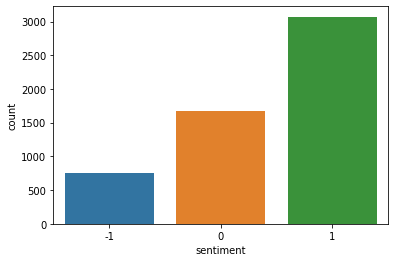

In [ ]:
sns.countplot(y_train)

We can see that there is an imbalance in the classes. Many tweets are corresponding to the positive class. We have to deal with this imabalnce problem as this may lead to the model biased towards the highest occuring class.

For this, we use __SMOTE(Synthetic Minority Oversampling Technique)__ technique. It is an oversampling technique which generates synthetic data for the minority class. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

In [ ]:
# import SMOTE module from imblearn library
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train_smote, y_train_smote = sm.fit_resample(tfidf_train, y_train.ravel())



print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0)))
print("After OverSampling, counts of label '-1': {}".format(sum(y_train_smote == -1)))

After OverSampling, counts of label '1': 3071
After OverSampling, counts of label '0': 3071
After OverSampling, counts of label '-1': 3071


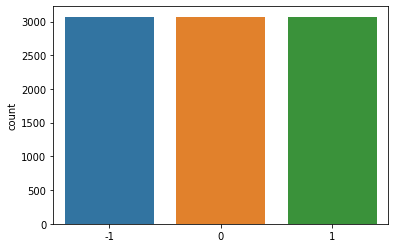

In [ ]:
sns.countplot(y_train_smote)

#### Without dealing with class imbalance problem and building a model:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:

rf = RandomForestClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1,
                                 n_jobs=2)

rf.fit(tfidf_train, y_train)

RandomForestClassifier(n_estimators=5, n_jobs=2, random_state=1)

In [ ]:
# Measure model performance
y_pred_rf = rf.predict(tfidf_val)

In [ ]:
# Prints the confusion matrix 
cm = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix\n")
print(cm)

print(classification_report(y_val,y_pred_rf))

Confusion Matrix

[[ 74  45  68]
 [ 14 338  65]
 [ 18  96 654]]
              precision    recall  f1-score   support

          -1       0.70      0.40      0.51       187
           0       0.71      0.81      0.75       417
           1       0.83      0.85      0.84       768

    accuracy                           0.78      1372
   macro avg       0.74      0.69      0.70      1372
weighted avg       0.77      0.78      0.77      1372



The accuracy obtained is 78%. We can say that the model can be improved for better classification.

__Building classification models after applying SMOTE on training dataset__

### MultiNominal Naive Bayes

In [ ]:
# Fitting Multinominal Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_smote, y_train_smote)

MultinomialNB()

In [ ]:
# testing
y_pred_nb = mnb.predict(tfidf_val)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_nb)

In [ ]:
cm
print(classification_report(y_val,y_pred_nb))

              precision    recall  f1-score   support

          -1       0.42      0.64      0.51       187
           0       0.80      0.53      0.64       417
           1       0.79      0.83      0.81       768

    accuracy                           0.71      1372
   macro avg       0.67      0.67      0.65      1372
weighted avg       0.74      0.71      0.71      1372



In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
score1 = accuracy_score(y_val,y_pred_nb)
print("Accuracy score is: {}%".format(round(score1*100,2)))

Accuracy score is: 71.28%


**Using Cross validation**

In [ ]:
# Prints the accuracy score by using Cross Validation
accuracy_nb = cross_val_score(mnb, X_train_smote, y_train_smote, cv=10, scoring='accuracy').mean()
print("Accuracy obtained by using Multinomial Naive Bayes Model is:",accuracy_nb)

Accuracy obtained by using Multinomial Naive Bayes Model is: 0.851962405288979


In [ ]:
# Prints the f1 score by using Cross Validation
f1_nb = cross_val_score(mnb, X_train_smote, y_train_smote, cv=10, scoring='f1_weighted').mean()
print("F1 score:",f1_nb)

F1 score: 0.8503093726539397


## Logistic Regression for MultiClass

In [ ]:
from sklearn.linear_model import LogisticRegression

lg= LogisticRegression(multi_class='multinomial', solver='lbfgs')
# Fitting the model
lg.fit(X_train_smote, y_train_smote)

LogisticRegression(multi_class='multinomial')

In [ ]:
# Predicts the labels
y_pred_lg = lg.predict(tfidf_val)

In [ ]:
# Prints the confusion matrix 
cm = confusion_matrix(y_val, y_pred_lg)
print("Confusion Matrix\n")
print(cm)

print(classification_report(y_val,y_pred_lg))

Confusion Matrix

[[116  24  47]
 [ 32 349  36]
 [ 27  93 648]]
              precision    recall  f1-score   support

          -1       0.66      0.62      0.64       187
           0       0.75      0.84      0.79       417
           1       0.89      0.84      0.86       768

    accuracy                           0.81      1372
   macro avg       0.77      0.77      0.77      1372
weighted avg       0.81      0.81      0.81      1372



The accuracy obtained is 81%

**Using Cross Validation**

In [ ]:
# Prints the accuracy score by using Cross Validation
accuracy_lg = cross_val_score(lg, X_train_smote, y_train_smote, cv=10, scoring='accuracy').mean()
print("Accuracy obtained by using MultiNomial Logistic Regression Model is:",accuracy_lg)

Accuracy obtained by using MultiNomial Logistic Regression Model is: 0.9141521876862131


In [ ]:
# Prints the f1 score by using Cross Validation
f1_lg = cross_val_score(lg, X_train_smote, y_train_smote, cv=10, scoring='f1_weighted').mean()
print("F1 score:",f1_lg)

F1 score: 0.9131476196881996


## Support Vector Machine

In [ ]:
from sklearn import svm

In [ ]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_smote, y_train_smote)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(tfidf_val)


In [ ]:
# Prints the confusion matrix 
cm = confusion_matrix(y_val, predictions_SVM)
print("Confusion Matrix\n")
print(cm)

print(classification_report(y_val,predictions_SVM))

Confusion Matrix

[[106  29  52]
 [ 23 347  47]
 [ 21  68 679]]
              precision    recall  f1-score   support

          -1       0.71      0.57      0.63       187
           0       0.78      0.83      0.81       417
           1       0.87      0.88      0.88       768

    accuracy                           0.83      1372
   macro avg       0.79      0.76      0.77      1372
weighted avg       0.82      0.83      0.82      1372



The accuracy obtained is 83%

**Using Cross Validation**

In [ ]:
# Prints the accuracy score
accuracy_SVM = cross_val_score(SVM, X_train_smote, y_train_smote, cv=10, scoring='accuracy').max()
print("Accuracy obtained by using SVM Classifier:",accuracy_SVM)

Accuracy obtained by using SVM Classifier: 0.9565689467969598


In [ ]:
# Prints the f1 score
f1_SVM = cross_val_score(SVM, X_train_smote, y_train_smote, cv=10, scoring='f1_weighted').mean()
print("F1 score:",f1_SVM)

F1 score: 0.9343918213798161


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

rf1 = RandomForestClassifier(criterion='gini',
                                 n_estimators=5,
                                 random_state=1,
                                 n_jobs=2)

rf1.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=5, n_jobs=2, random_state=1)

In [ ]:
# Measure model performance
y_pred_rf = rf1.predict(tfidf_val)

In [ ]:
# Prints the confusion matrix 
cm = confusion_matrix(y_val, y_pred_rf)
print("Confusion Matrix\n")
print(cm)

print(classification_report(y_val,y_pred_rf))

Confusion Matrix

[[102  43  42]
 [ 21 323  73]
 [ 45 135 588]]
              precision    recall  f1-score   support

          -1       0.61      0.55      0.57       187
           0       0.64      0.77      0.70       417
           1       0.84      0.77      0.80       768

    accuracy                           0.74      1372
   macro avg       0.70      0.70      0.69      1372
weighted avg       0.75      0.74      0.74      1372



The accuracy obtained is 74%

**Using Cross validation**

In [ ]:
# Prints the accuracy score
accuracy_rf = cross_val_score(rf, X_train_smote, y_train_smote, cv=10, scoring='accuracy').max()
print("Accuracy obtained by using Random Forest Classifier:",accuracy_rf)

Accuracy obtained by using Random Forest Classifier: 0.9011943539630836


In [ ]:
# Prints the f1 score
f1_rf = cross_val_score(rf, X_train_smote, y_train_smote, cv=10, scoring='f1_weighted').mean()
print("F1 score:",f1_rf)

F1 score: 0.8552275311246319


## Comparing Model Accuracy of all the Models used

In [ ]:
Algo=['Multinominal Naive Bayes(TF-IDF)','LogisticRegression(TF-IDF)','RandomForest(TF-IDF)','SupportVectorMachine(TF-IDF)']
score = [accuracy_nb,accuracy_lg,accuracy_rf,accuracy_SVM]
compare_acc=pd.DataFrame({'Model':Algo,'Accuracy':score},index=[i for i in range(1,5)])
compare_acc.T

,1,2,3,4
Model,Multinominal Naive Bayes(TF-IDF),LogisticRegression(TF-IDF),RandomForest(TF-IDF),SupportVectorMachine(TF-IDF)
Accuracy,0.851962,0.914152,0.901194,0.956569


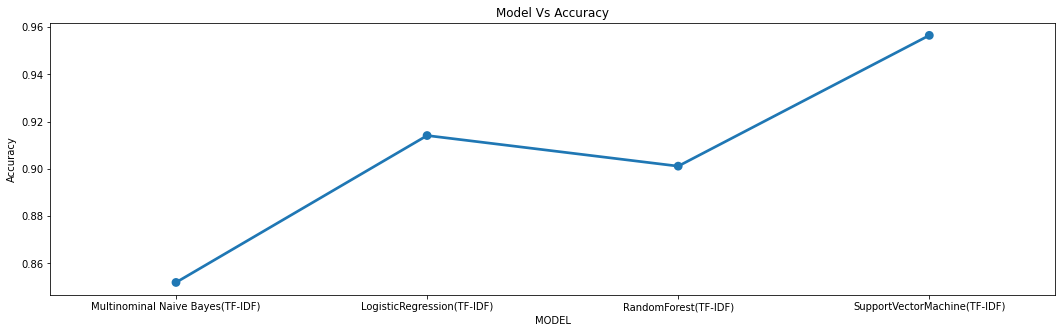

In [ ]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='Accuracy',data=compare_acc)

plt.title('Model Vs Accuracy')
plt.xlabel('MODEL')
plt.ylabel('Accuracy')

plt.show()

__SVM gives the highest accuracy of around 95% among all other models implemented__

In [ ]:
Algo=['Bernoulli Naive Bayes(TF-IDF)','LogisticRegression(TF-IDF)','RandomForest(TF-IDF)','SupportVectorMachine(TF-IDF)']
score = [f1_nb,f1_lg,f1_rf,f1_SVM]
compare=pd.DataFrame({'Model':Algo,'F1 score':score},index=[i for i in range(1,5)])
compare.T

,1,2,3,4
Model,Bernoulli Naive Bayes(TF-IDF),LogisticRegression(TF-IDF),RandomForest(TF-IDF),SupportVectorMachine(TF-IDF)
F1 score,0.850309,0.913148,0.855228,0.934392


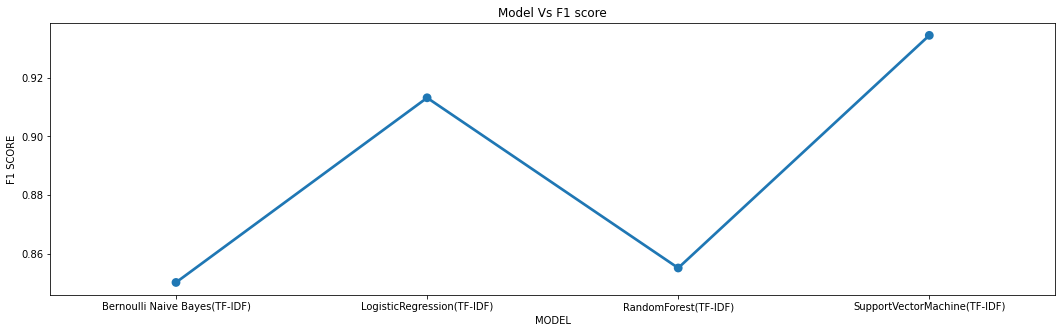

In [ ]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1 score',data=compare)

plt.title('Model Vs F1 score')
plt.xlabel('MODEL')
plt.ylabel('F1 SCORE')

plt.show()

__We can observe that the highest F1 score has been obtained by using Support Vector Machine which is 93%__